In [5]:
from env.workload import Workload, Workflow
from schedule.taskNcpEnv import runEnv
from schedule.schedule import Scheduler
from model.sac import SAC
from model.dqn import DQN
import torch
import datetime
import time
import argparse


def get_args():
    parser = argparse.ArgumentParser(description="Hyperparameter parser")

    # 添加超参数
    parser.add_argument('--random_seed', type=int, default=50, help='Random seed')
    parser.add_argument('--buffer_size', type=int, default=1000, help='Buffer size')
    parser.add_argument('--batch_size', type=int, default=256, help='Batch size')
    parser.add_argument('--hidden_size', type=int, default=128, help='Hidden layer size')
    parser.add_argument('--target_update', type=int, default=100, help='Target update frequency')
    parser.add_argument('--action_num', type=int, default=16, help='Number of actions')
    parser.add_argument('--state_dim', type=int, default=6 + 3 * 16, help='State dimension')  # 计算 state_dim
    parser.add_argument('--arrival_rate', type=float, default=0.1 / 60, help='Arrival rate (per second)')
    parser.add_argument('--device', type=str, default="cuda:0" if torch.cuda.is_available() else "cpu", help='Device (CPU or CUDA)')
    parser.add_argument('--episode_number', type=int, default=100, help='Number of episodes')
    parser.add_argument('--wf_number', type=int, default=10, help='Number of workflows')
    parser.add_argument('--beta', type=float, default=0.6, help='Weight balancing budget and time')
    parser.add_argument('--discount_factor', type=float, default=0.9, help='Discount factor for future rewards')
    parser.add_argument('--lr', type=float, default=5e-3, help='Learning rate')
    parser.add_argument('--l2_weight_decay', type=float, default=1e-4, help='L2 regularization weight decay')
    parser.add_argument('--debug', type=bool, default=False, help='Debug mode')

    args, unknown = parser.parse_known_args()  # 解析已知参数，忽略未知参数
    return args

args = get_args()

In [6]:
train_dataset_50 = "data/train/_50"
train_dataset_100 = "data/train/_100"
train_dataset_200 = "data/train/_200"
save_model_path_50 = '_50.pth'
save_model_path_100 = '_100.pth'
save_model_path_200 = '_200.pth'
agent1 = DQN(args.state_dim, args.action_num, args.batch_size, args.buffer_size, args.hidden_size, args.lr, args.device, args.discount_factor, debug=args.debug);
agent2 = SAC(args.state_dim, args.action_num, args.batch_size, args.buffer_size, args.hidden_size, args.lr, args.device)
agent3 = DQN(args.state_dim, args.action_num, args.batch_size, args.buffer_size, args.hidden_size, args.lr, args.device, args.discount_factor, args.l2_weight_decay); #R-DQN

Adjusting learning rate of group 0 to 5.0000e-03.
Adjusting learning rate of group 0 to 5.0000e-03.


In [7]:
def train(episode_number, agent, workflow_number, train_wf_path, save_model_path,arrival_rate, debug=False):
  mean_makespan = [];
  mean_cost = []
  time_rate = []
  cost_rate = []
  succes_both_rate = []
  episode_arr = []
  
  agent.net.train(True)
  scheduler = Scheduler(agent, args.action_num, args.state_dim, args.batch_size, args.beta, debug)
  print("start at:", str(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")));
  start = time.time();
        
  for episode in range(1, episode_number+1):
    Workflow.reset();
    Workload.reset();
  
    print("episode:",episode,"="*70)
    t, c, tr, cr, both = runEnv(train_wf_path, scheduler.run, episode*10, wf_number=workflow_number, action_num = args.action_num, 
                                  arrival_rate = arrival_rate, debug=debug);
    mean_makespan.append(t)
    mean_cost.append(c)
    time_rate.append(tr)
    cost_rate.append(cr)
    succes_both_rate.append(both)
    episode_arr += ([episode])
    
        
  s = str(datetime.timedelta(seconds=time.time()-start));
  print("total train time:", s);
  scheduler.trainPlotFinal(mean_makespan, mean_cost,time_rate, cost_rate, succes_both_rate)
  scheduler.save_hyperparameters(args)
  agent.save_model(save_model_path)

start at: 2024-10-11 19:33:19
episode: 1 ======================================================================
[Budget] wf.path: data/train/_50/MONTAGE.n.50.6.dax, wf.budget = 280.07, wf.cost = 581.08, distance = -301.01
[Budget] wf.path: data/train/_50/MONTAGE.n.50.16.dax, wf.budget = 509.22, wf.cost = 518.26, distance = -9.04
[Budget] wf.path: data/train/_50/MONTAGE.n.50.18.dax, wf.budget = 25.46, wf.cost = 644.11, distance = -618.65
[Deadline] wf.path: data/train/_50/LIGO.n.50.3.dax, wf.deadline = 10146.36, wf.makespan = 13012.74, distance = -2866.38
[Deadline] wf.path: data/train/_50/LIGO.n.50.10.dax, wf.deadline = 3246.05, wf.makespan = 13269.78, distance = -10023.73
[Deadline] wf.path: data/train/_50/LIGO.n.50.6.dax, wf.deadline = 3283.34, wf.makespan = 17007.75, distance = -13724.41
[Deadline] wf.path: data/train/_50/LIGO.n.50.14.dax, wf.deadline = 7464.07, wf.makespan = 18248.75, distance = -10784.68
[Deadline] wf.path: data/train/_50/LIGO.n.50.19.dax, wf.deadline = 6515.04, w

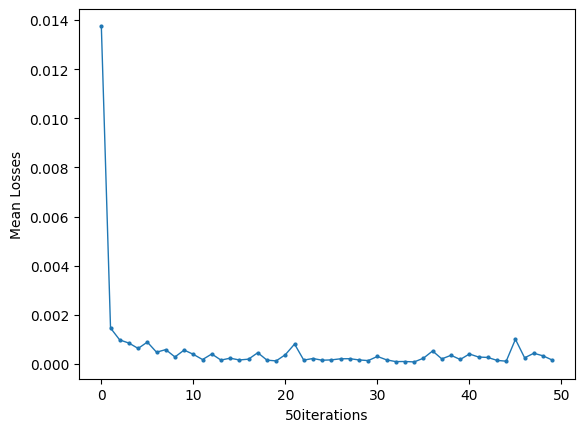

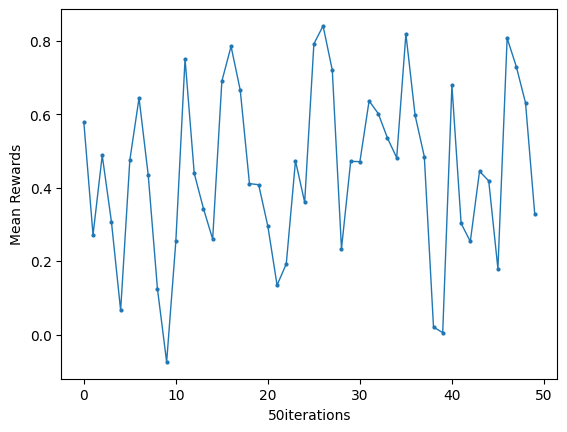

[Budget] wf.path: data/train/_50/MONTAGE.n.50.2.dax, wf.budget = 381.92, wf.cost = 627.72, distance = -245.80
[Deadline] wf.path: data/train/_50/LIGO.n.50.13.dax, wf.deadline = 6749.67, wf.makespan = 7507.53, distance = -757.86
[Deadline] wf.path: data/train/_50/LIGO.n.50.7.dax, wf.deadline = 2707.66, wf.makespan = 8979.82, distance = -6272.16
[Budget] wf.path: data/train/_50/MONTAGE.n.50.2.dax, wf.budget = 25.46, wf.cost = 462.43, distance = -436.97
[Deadline] wf.path: data/train/_50/MONTAGE.n.50.2.dax, wf.deadline = 1317.35, wf.makespan = 10319.15, distance = -9001.80
[Deadline] wf.path: data/train/_50/LIGO.n.50.11.dax, wf.deadline = 1311.24, wf.makespan = 9880.15, distance = -8568.91
[Deadline] wf.path: data/train/_50/LIGO.n.50.5.dax, wf.deadline = 1342.71, wf.makespan = 7870.76, distance = -6528.05
[Budget] wf.path: data/train/_50/MONTAGE.n.50.7.dax, wf.budget = 229.15, wf.cost = 637.24, distance = -408.09
[Deadline] wf.path: data/train/_50/MONTAGE.n.50.7.dax, wf.deadline = 936.91,

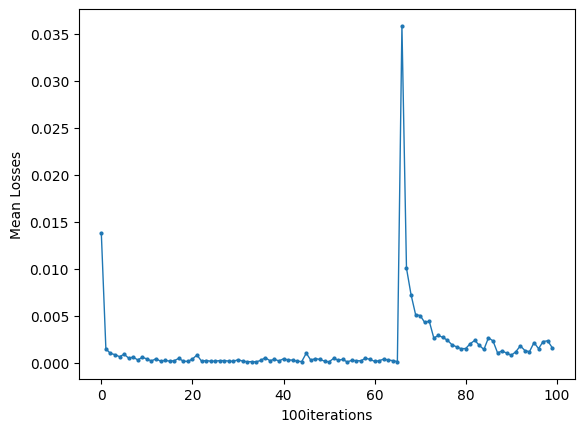

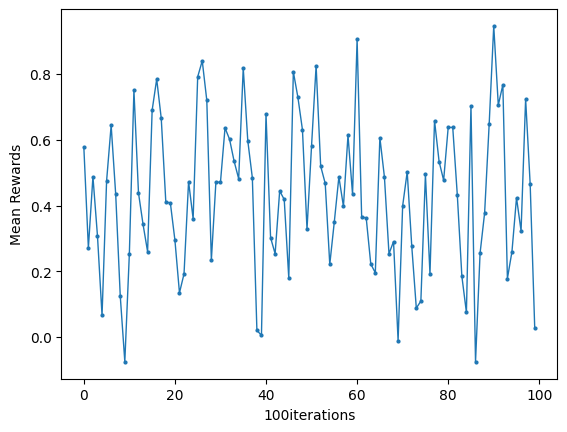

[Deadline] wf.path: data/train/_50/LIGO.n.50.5.dax, wf.deadline = 4028.14, wf.makespan = 11905.59, distance = -7877.45
[Budget] wf.path: data/train/_50/MONTAGE.n.50.18.dax, wf.budget = 509.22, wf.cost = 552.09, distance = -42.87
[Deadline] wf.path: data/train/_50/MONTAGE.n.50.18.dax, wf.deadline = 1434.48, wf.makespan = 9173.31, distance = -7738.83
[Deadline] wf.path: data/train/_50/LIGO.n.50.12.dax, wf.deadline = 9529.61, wf.makespan = 11047.63, distance = -1518.02
[Budget] wf.path: data/train/_50/MONTAGE.n.50.13.dax, wf.budget = 101.84, wf.cost = 573.99, distance = -472.15
[Deadline] wf.path: data/train/_50/MONTAGE.n.50.13.dax, wf.deadline = 685.46, wf.makespan = 11213.16, distance = -10527.70
[Budget] wf.path: data/train/_50/MONTAGE.n.50.3.dax, wf.budget = 432.84, wf.cost = 549.13, distance = -116.29
[Deadline] wf.path: data/train/_50/MONTAGE.n.50.3.dax, wf.deadline = 379.33, wf.makespan = 10397.77, distance = -10018.44
[Deadline] wf.path: data/train/_50/LIGO.n.50.5.dax, wf.deadline

KeyboardInterrupt: 

In [8]:
train(args.episode_number, agent1, args.wf_number, train_dataset_50, save_model_path_50, args.arrival_rate, args.debug);